In [147]:
from ExoRIM import RIM, PhysicalModel
from ExoRIM.operators import Baselines, redundant_phase_closure_operator as RCPO, \
            closure_fourier_matrices as CBP, NDFTM
from ExoRIM.loss import MSE
from ExoRIM.log_likelihood import chi_squared as chisq, chisq_x_transformation
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt
from IPython.display import Image as Image1
from PIL import Image
from ExoRIM.definitions import mas2rad, rad2mas, default_hyperparameters as hparams
from datetime import datetime
from celluloid import Camera
import json
import matplotlib
import pickle
%matplotlib inline

# Introduction

Aperture masking is a way to measure the degree of spatial coherence of an image. What this means is that we can measure how good of an interference pattern we can get from multiple copies of an image emerging from different pinholes (telescope).


(-0.5, 63.5, 63.5, -0.5)

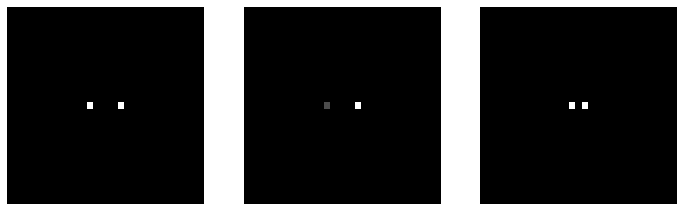

In [148]:
# Suppose two pinholes, delta functions
pixels = 64

x = np.arange(pixels) - pixels//2 + 0.5
x, y = np.meshgrid(x, x)
image = np.zeros_like(x)
image += (np.abs(x - 5) < 1) & (np.abs(y) < 1)
image2 = np.copy(image)
image += ((np.abs(x + 5) < 1) & (np.abs(y) < 1)) * 1.
image2 += ((np.abs(x + 5) < 1) & (np.abs(y) < 1)) * 0.3
image3 =  np.zeros_like(x)
image3 += (np.abs(x - 2) < 1) & (np.abs(y) < 1)
image3 += (np.abs(x + 2) < 1) & (np.abs(y) < 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.imshow(image, cmap="gray")
ax1.axis("off")
ax2.imshow(image2, cmap="gray")
ax2.axis("off")
ax3.imshow(image3, cmap="gray")
ax3.axis("off")

The interference pattern is obtained by the Fourier Transform (an approximation of the Franhofer Diffraction Integral in the far field regime).

(-0.5, 63.5, 63.5, -0.5)

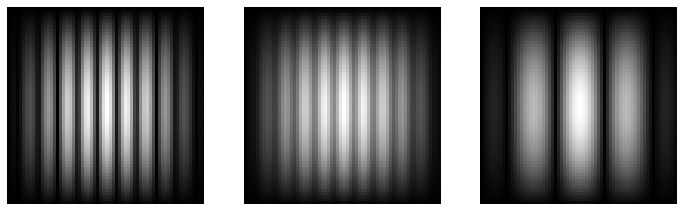

In [149]:
interference = np.fft.fftshift(np.fft.fft2(image))
interference2 = np.fft.fftshift(np.fft.fft2(image2))
interference3 = np.fft.fftshift(np.fft.fft2(image3))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.imshow(np.abs(interference), cmap="gray")
ax1.axis("off")
ax2.imshow(np.abs(interference2), cmap="gray")
ax2.axis("off")
ax3.imshow(np.abs(interference3), cmap="gray")
ax3.axis("off")

We are interested in the *Visibility* function, which is related to the *coherence* function amplitude.

$$
    V \equiv \frac{I_{\max} - I_{\min}}{I_{\max} + I_{\min}}
$$

Text(0.5, 1.0, 'V=1.0')

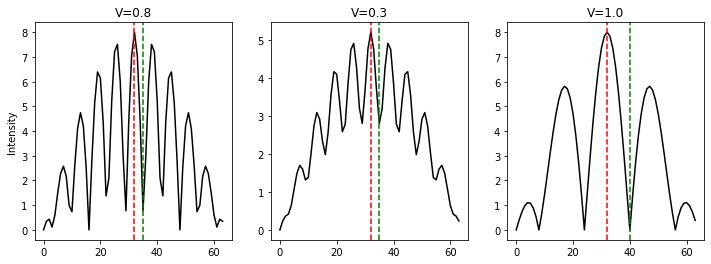

In [150]:
I = np.abs(interference[32, :]) 
I2 = np.abs(interference2[32, :])
I3 = np.abs(interference3[32, :])

imax = pixels//2
imin = pixels//2 + 3 * (pixels//64)
imin3 = pixels//2 + 8 * (pixels//64)

V = (I[imax] - I[imin]) / (I[imax] + I[imin])
V2 = (I2[imax] - I2[imin]) / (I2[imax] + I2[imin])
V3 = (I3[imax] - I3[imin3]) / (I3[imax] + I3[imin3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(I, "k")
ax1.axvline(imax, ls="--", color="r")
ax1.axvline(imin, ls="--", color="g")
ax1.set_ylabel("Intensity")
ax1.set_title(f"V={V:.1f}")

ax2.plot(I2, "k")
ax2.axvline(imax, ls="--", color="r")
ax2.axvline(imin, ls="--", color="g")
ax2.set_title(f"V={V2:.1f}")

ax3.plot(I3, "k")
ax3.axvline(imax, ls="--", color="r")
ax3.axvline(imin3, ls="--", color="g")
ax3.set_title(f"V={V3:.1f}")

The coherence function is a complex numbers that measure more holistically this degree of coherence. 
$$
    \gamma = 
    \frac{\langle f(\mathbf{r}_1, t) \tilde{f}(\mathbf{r}_2, t)) \rangle }{\sqrt{
    \langle |f(\mathbf{r}_1, t)|^2  \rangle 
     \langle |\tilde{f}(\mathbf{r}_2, t)|^2  \rangle 
    }}
$$
This is an important function because it is related to the intrisic intensity distribution of the source $I(\theta_x, \theta_y)$ through an inverse Fourier Transform. (*Van Cittert-Zernike Theorem*). The idea of interferometry is therefore to have multiple pinholes in order to reconstruct the source distribution to a greater 


# Problem Statement

Our problem is due to atmospheric noise! The phase of the coherence function cannot be retrieved correctly. With our example, this means the separation between a maximum and a minimum cannot be correctly estimated in a baseline (phase error amplitude is often larger than $2\pi$ over the time of integration).

To solve this problem, we use an observable related to the third order cumulant called the bispectra. It has a very nice property, in that indiviual aperture errors cancel each others and do not affect the bispectra phase (or closure phase).

In practice, we take the interferogram of 3 baselines and multiply them together. Then we gather the phase of this product.

The image reconstruction task is a an ill-posed inverse problem of the non linear equation
$$
y = 
\left(
\begin{matrix}
    \big\vert \mathcal{F}(x) \big\vert \\
    \text{arg} \left(  \mathcal{F}_1(x) \odot\tilde{\mathcal{F}}_2(x) \odot \mathcal{F}_3(x)\right)
\end{matrix}
\right)
+ \eta
$$
We try to solve this by maximizing a likelihood
$$
    \tilde{x} = \underset{x \in \mathbb{R}^{p \times p}}{\text{argmax}}\, \log p(y \mid x) + \log p_\theta(x)
$$

Of course, we use the $\chi^2$ as an estimate of $-\log p(y \mid x)$.

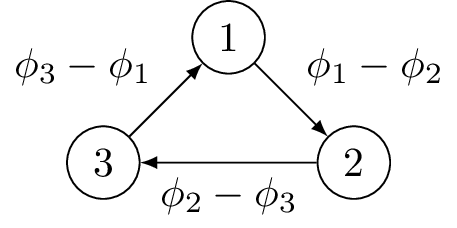

In [151]:
Image1("../analysis/tex/closure_phase.png")

## Dataset

Text(0.5, 1.0, 'mask')

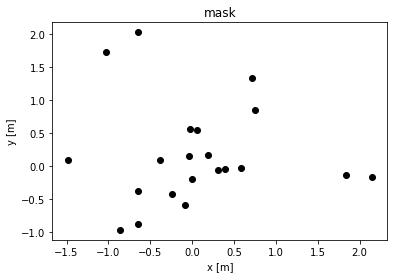

In [152]:
# parameters
pixels = 128
batch_size = 16
wavel = 0.e-6
N = 21
mask = np.random.normal(0, 1, (N, 2))
SNR = 100
phase_std = 1

#settings
basepath = os.getenv("project")
basedir = os.path.join(basepath, "ExoRIM") # for training
datapath = os.path.join(basepath, "data", "natural_images", "flower")
dtype = tf.float64
AUTOTUNE = tf.data.experimental.AUTOTUNE
checkpoint_dir = "../models/ideal_fft_forward/"
results_dir = "../results/ideal_fft_forward/"
logs = "../logs/ideal_fft_forward/"
plt.plot(mask[:, 0], mask[:, 1], "ko")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("mask")

In [153]:
phys = PhysicalModel(pixels, mask, wavel, SNR, phase_std)
samples = []
def dataset(split=0.9):
    files = list(os.walk(datapath))[0][2]
    images = []
    data = []
    N = len(files)
    for file in files:
        im = np.asarray(Image.open(os.path.join(datapath, file)))
        im = tf.image.rgb_to_grayscale(im)
        Y = tf.image.resize(im, [pixels, pixels]) / 255
        samples.append(Y.numpy()[..., 0])
        X = phys.forward(tf.reshape(Y, (1, -1)))
        Y = tf.reshape(Y, [pixels, pixels, 1])
        images.append(Y)
        data.append(tf.reshape(X, [-1]))
    x = tf.data.Dataset.from_tensor_slices(data)
    y = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf.data.Dataset.zip((x, y))
    dataset = dataset.cache()              # accelerate the second and subsequent iterations over the dataset
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)  # Batch is prefetched
    train_set = dataset.take(int(N/batch_size * split))
    test_set = dataset.skip(int(N/batch_size * split))
    return train_set, test_set
D_train, D_test = dataset()

210 distinct baselines found. Mask has 0 redundant baselines
There are 190 independant closure phases


In [154]:
for x, y in D_test.as_numpy_iterator():
    print(x.shape)
    print(x.dtype)
    print(y.shape)
    print(y.dtype)
    break

(16, 400)
complex64
(16, 128, 128, 1)
float32


210 distinct baselines found. Mask has 0 redundant baselines


Text(0.5, 0, '$\\theta_x$ [mas]')

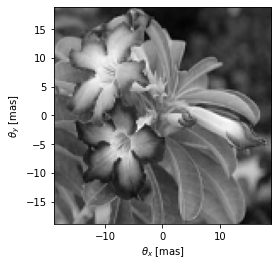

In [175]:
im = samples[100]

# Get physically scaled angle coordinates
theta = (np.arange(pixels) - pixels//2 + 0.5) * phys.plate_scale# mas
uv_samples = Baselines(mask).UVC / wavel
theta_samples = rad2mas(1/uv_samples)
plt.imshow(im, cmap="gray", extent=[theta.min(), theta.max()]*2)
plt.ylabel(r"$\theta_y$ [mas]")
plt.xlabel(r"$\theta_x$ [mas]")

Text(0, 0.5, '$f_y$ [mas$^{-1}$]')

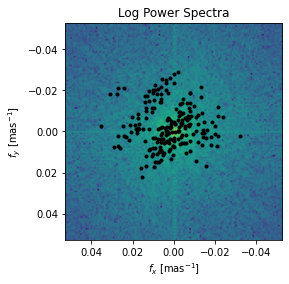

In [176]:
# Show sampling
ideal_data = np.fft.fftshift(np.fft.fft2(im))
plt.imshow(np.log(np.abs(ideal_data)**2), extent=[1/theta.max(), 1/theta.min()]*2)
plt.plot(1/theta_samples[:, 0], 1/theta_samples[:, 1], "k.")
plt.title("Log Power Spectra")
plt.xlabel(r"$f_x$ [mas$^{-1}$]")
plt.ylabel(r"$f_y$ [mas$^{-1}$]")

# Model 

To solve the ill-posed inverse problem, we use a recurrent neural net architecture to try and estimate the inverse operation (get y from x). We call it a __Recurrent Inference Machine__ or RIM for short. With this model, the gradient update equation is simplified in that we do not need to specify a prior model for the data (we hope it is learned implicitely during training).

$$
    x_{t + 1} = x_t + g_\phi( \nabla_{y \mid x}, x_t)
$$
The model learns a function $g_\phi$ that take the log likelihood gradient and the estimated image at the previous step and tries to learn the gradient update through the training.

In [157]:

hparams["pixels"] = pixels
hparams["steps"] = 6
hparams["Downsampling Block"] = [
    {"Conv_Downsample1": {
        "kernel_size": [
          3,
          3
        ],
        "filters": 1,
        "strides": [
          2,
          2
        ]
      }},
      {"Conv_Downsample2": {
        "kernel_size": [
          5,
          5
        ],
        "filters": 8,
        "strides": [
          2,
          2
        ]
      }},
    {
        "Conv_Downsample3": {
        "kernel_size": [
          7,
          7
        ],
        "filters": 16,
        "strides": [
          2,
          2
        ]
      }}
]
hparams["Upsampling Block"] = [
    {
      "Conv_Fraction_Stride1": {
        "kernel_size": [
          3,
          3
        ],
        "filters": 16,
        "strides": [
          2,
          2
        ]
      }
    },
        {
      "Conv_Fraction_Stride2": {
        "kernel_size": [
          5,
          5
        ],
        "filters": 16,
        "strides": [
          2,
          2
        ]
      }
    },
        {
      "Conv_Fraction_Stride3": {
        "kernel_size": [
          7,
          7
        ],
        "filters": 16,
        "strides": [
          2,
          2
        ]
      }
    }
]
rim = RIM(phys, hparams)

## Training

In [158]:
loss = MSE()
create_dir = False
if create_dir:
    date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    results_dir = os.path.join(basedir, "results", date)
    os.mkdir(results_dir)
    models_dir = os.path.join(basedir, "models", date)
    os.mkdir(models_dir)
    data_dir = os.path.join(basedir, "data", date)
    os.mkdir(data_dir)
    train_dir = os.path.join(data_dir, "train")
    os.mkdir(train_dir)
    test_dir = os.path.join(data_dir, "test")
    os.mkdir(test_dir)

    # another approach to save results using tensorboard and wandb
    logdir = os.path.join(basedir, "logs", date)
    os.mkdir(logdir)
    os.mkdir(os.path.join(logdir, "train"))
    os.mkdir(os.path.join(logdir, "test"))

In [159]:
boundaries = [2000, 5000]
values = [1e-3, 1e-4, 1e-5]
learning_rate_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

vis_transform = lambda Y, phys: phys.forward(Y)[..., :phys.p]
cp_transform = lambda Y, phys: tf.math.angle(phys.forward(Y)[..., phys.p:])
amp_transform = lambda Y, phys: tf.math.abs(phys.forward(Y)[..., :phys.p])

metrics = {
    "Chi_squared_visibilities": lambda Y_pred, Y_true: tf.reduce_mean(chisq["visibility"](
        Y_pred, vis_transform(Y_true, phys), phys
    )),
    "Chi_squared_closure_phases": lambda Y_pred, Y_true: tf.reduce_mean(chisq["closure_phasor"](
        Y_pred, cp_transform(Y_true, phys), phys
    )),
    "Chi_squared_amplitude": lambda Y_pred, Y_true: tf.reduce_mean(chisq["visibility_amplitude"](
        Y_pred, amp_transform(Y_true, phys), phys
    ))
}

In [161]:
history = rim.fit(
        train_dataset=D_train,
        test_dataset=D_test,
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
        max_time=1,
        cost_function=loss,
        min_delta=1e-2,
        patience=5,
        metrics=metrics,
        track="train_loss",
        checkpoints=5,
        output_dir=results_dir,
        checkpoint_dir=models_dir,
        max_epochs=40,
        logdir=logdir,
        output_save_mod={
            "index_mod": 100,
            "epoch_mod": 1,
            "step_mod": 1,
            "timestep_mod": 1
        }
    )

1: train_loss=3.44e+01 | val_loss=1.99e+01 | learning rate=1.00e-03
2: train_loss=1.95e+01 | val_loss=6.35e+00 | learning rate=1.00e-03
3: train_loss=9.36e+00 | val_loss=4.61e+00 | learning rate=1.00e-03
4: train_loss=8.90e+00 | val_loss=4.40e+00 | learning rate=1.00e-03
5: train_loss=8.66e+00 | val_loss=4.17e+00 | learning rate=1.00e-03
6: train_loss=8.51e+00 | val_loss=4.09e+00 | learning rate=1.00e-03
7: train_loss=8.36e+00 | val_loss=3.83e+00 | learning rate=1.00e-03
8: train_loss=8.20e+00 | val_loss=3.67e+00 | learning rate=1.00e-03
9: train_loss=8.07e+00 | val_loss=3.53e+00 | learning rate=1.00e-03
10: train_loss=7.97e+00 | val_loss=3.41e+00 | learning rate=1.00e-03
11: train_loss=7.85e+00 | val_loss=3.31e+00 | learning rate=1.00e-03
12: train_loss=7.76e+00 | val_loss=3.22e+00 | learning rate=1.00e-03
13: train_loss=7.67e+00 | val_loss=3.13e+00 | learning rate=1.00e-03
14: train_loss=7.59e+00 | val_loss=3.05e+00 | learning rate=1.00e-03
15: train_loss=7.52e+00 | val_loss=2.98e+00

In [162]:
%%HTML
<video width=600 controls>
    <source src="example_video.mp4", type="video/mp4">
</video>

In [163]:
# update of nested dictionaries
import collections.abc
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

images = {}
for file in glob.glob(os.path.join(results_dir, "output*")):
    name = os.path.split(file)[-1]
    if name[-3:] == "png":
        epoch = int(name[7:10])
        index = int(name[11:15])
        step = int(name[16:18])
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
            update(images, {index: {epoch : {step: im}}})
    elif name[-3:] == "txt":
        epoch = int(name[7:11])
        index = int(name[12:16])
        step = int(name[17:19])
        im = np.loadtxt(file)
        update(images, {index: {epoch : {step: im}}})
images.keys()

log_grad = {}
for file in glob.glob(os.path.join(results_dir, "grad_[0-9]*")):
    name = os.path.split(file)[-1]
    epoch = int(name[5:9])
    index = int(name[10:14])
    step = int(name[15:17])
    g = np.loadtxt(file)
    update(log_grad, {index: {epoch : {step: g}}})
with open(os.path.join(results_dir, "grad_and_weights.pickle"), "rb") as f:
    grad_and_weights = pickle.load(f)


In [164]:
%%capture

index = 0
step = 5
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
plt.title("Output")
for key in sorted(list(selected_image.keys())):
    im = selected_image[key][step]
    plt.imshow(im, cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "output.mp4"), writer="ffmpeg")
anim1 = HTML(animation.to_html5_video())

In [165]:
anim1

In [166]:
%%capture

fig = plt.figure()
cam = Camera(fig)
selected_grad = log_grad[index]
for key in sorted(list(selected_grad.keys())):
    plt.imshow(selected_grad[key][step])
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "log_likelihood_grad.mp4"), writer="ffmpeg")
anim3 = HTML(animation.to_html5_video())

In [167]:
anim3

In [168]:
for i in rim.model.trainable_weights:
    print(i.name)

RIM/Conv_Downsample1/kernel:0
RIM/Conv_Downsample1/bias:0
RIM/Conv_Downsample2/kernel:0
RIM/Conv_Downsample2/bias:0
RIM/Conv_Downsample3/kernel:0
RIM/Conv_Downsample3/bias:0
RIM/Conv_1/kernel:0
RIM/Conv_1/bias:0
RIM/Conv_2/kernel:0
RIM/Conv_2/bias:0
RIM/Conv_Fraction_Stride1/kernel:0
RIM/Conv_Fraction_Stride1/bias:0
RIM/Conv_Fraction_Stride2/kernel:0
RIM/Conv_Fraction_Stride2/bias:0
RIM/Conv_Fraction_Stride3/kernel:0
RIM/Conv_Fraction_Stride3/bias:0
RIM/TConv_1/kernel:0
RIM/TConv_1/bias:0
RIM/TConv_2/kernel:0
RIM/TConv_2/bias:0
RIM/batch_normalization_25/gamma:0
RIM/batch_normalization_25/beta:0
RIM/batch_normalization_26/gamma:0
RIM/batch_normalization_26/beta:0
RIM/batch_normalization_27/gamma:0
RIM/batch_normalization_27/beta:0
RIM/batch_normalization_28/gamma:0
RIM/batch_normalization_28/beta:0
RIM/batch_normalization_29/gamma:0
RIM/batch_normalization_29/beta:0
RIM/conv_gru_10/conv2d_30/kernel:0
RIM/conv_gru_10/conv2d_30/bias:0
RIM/conv_gru_10/conv2d_31/kernel:0
RIM/conv_gru_10/co

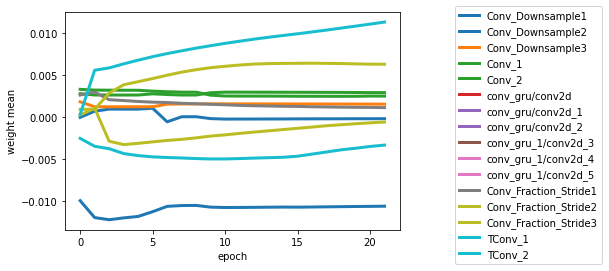

In [169]:
batch = 0
map_layer_to_depth = {
    "RIM/Conv_Downsample1": 0,
    "RIM/Conv_Downsample2": 1,
    "RIM/Conv_Downsample3": 2,
    "RIM/Conv_1": 3,
    "RIM/Conv_2": 4,
    "RIM/conv_gru/conv2d": 5,
    "RIM/conv_gru/conv2d_1": 6,
    "RIM/conv_gru/conv2d_2": 7,
    "RIM/conv_gru_1/conv2d_3": 8,
    "RIM/conv_gru_1/conv2d_4": 9,
    "RIM/conv_gru_1/conv2d_5": 10,
    "RIM/Conv_Fraction_Stride1": 11,
    "RIM/Conv_Fraction_Stride2": 12,
    "RIM/Conv_Fraction_Stride3": 13,
    "RIM/TConv_1": 14,
    "RIM/TConv_2": 15
}
inv_map = {v: k for k, v in map_layer_to_depth.items()}

kernel_weight_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_max = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_min = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
for layer_name in grad_and_weights.keys():
    if "kernel" in layer_name:
        layer = layer_name[:-len("/kernel:0")]
        try:
            depth = map_layer_to_depth[layer]
        except KeyError:
            continue
        for epoch, d in grad_and_weights[layer_name].items():
            kernel_weight_mean[depth].append(d[batch]["weight_mean"])
            kernel_weight_var[depth].append(d[batch]["weight_var"])
            kernel_grad_mean[depth].append(d[batch]["grad_mean"])
            kernel_grad_var[depth].append(d[batch]["grad_var"])
            kernel_weight_max[depth].append(d[batch]["weight_max"])
            kernel_weight_min[depth].append(d[batch]["weight_min"])
cmap = matplotlib.cm.get_cmap("tab10")
norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_weight_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("RIM/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight mean")
plt.savefig(os.path.join(results_dir, "weight_mean.png"))

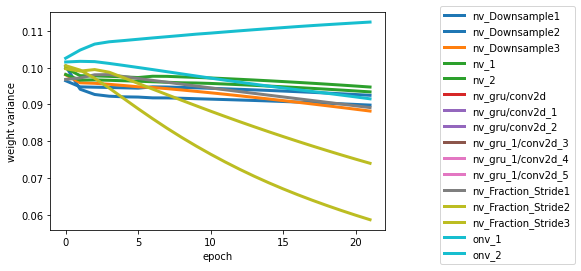

In [170]:
for depth, data in enumerate(kernel_weight_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight variance")
plt.savefig(os.path.join(results_dir, "weight_var.png"))

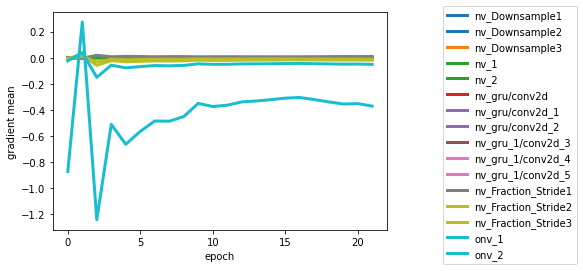

In [171]:
for depth, data in enumerate(kernel_grad_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient mean")
# plt.yscale("log")
plt.savefig(os.path.join(results_dir, "backpropgrad_mean.png"))

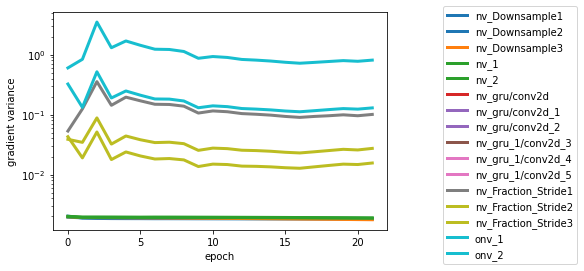

In [172]:
for depth, data in enumerate(kernel_grad_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient variance")
plt.yscale("log")
plt.savefig(os.path.join(results_dir, "backpropgrad_var.png"))